In [2]:
from statsmodels.iolib.summary2 import summary_col
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import statsmodels.api as sm

In [3]:
url = 'https://github.com/SofiyaLyn/Thesis/raw/main/almostcleaned_data.csv'
cleaned_data = pd.read_csv(url)
cleaned_data.head()

,Year,Country,"Proceeds_Amount_+_Over_Sold_This_Market_(USD,_mln)",IPO_market_share,New_Business,IPOs_Number_of_Issues,P/E_Ratio,E/P_ratio,Stock_Market_Index,Interest_rate_up_to_1_mln,...,Aver_interest_rate_to_nonfinance,Real_GDP_Growth_(%),Nominal_GDP_($B),Population_(M),Population_Growth_(%),GDP_Per_Capita_($),Real_Private_Consumption_Growth_(%),Real_Government_Consumption_Growth_(%),Real_Gross_Fixed_Investment_Growth_(%),Industrial_Production_Growth_(%)
0,2009,Hungary,0.00,0.00,42046,1,15.2913,0.07,"21,227.01",NaN,...,#DIV/0!,-3.49,52.02,7.47,(0.67),"6,961.09",-4.69,0.00,-15.95,-20.18
1,2010,Hungary,179.37,64.03,"44,269.00",4,12.1724,0.08,"21,327.07",9.40,...,8.61,1.39,50.68,7.43,(0.65),"6,825.90",1.54,6.13,-19.09,14.13
2,2011,Hungary,0.00,0.00,"52,217.00",1,10.8504,0.09,"16,974.24",9.30,...,8.495,2.36,57.68,7.38,(0.62),"7,817.14",2.14,0.66,-3.66,17.22
3,2012,Hungary,2.93,1.05,"32,311.00",1,12.6385,0.08,"18,173.20",10.46,...,9.65,0.49,54.30,7.33,(0.61),"7,403.74",2.92,-0.27,2.00,2.32
4,2013,Hungary,1.97,0.70,"28,207.00",1,10.6615,0.09,"18,564.08",8.79,...,8.09,-0.59,55.81,7.29,(0.60),"7,655.79",-3.24,2.76,-0.42,-0.98


In [4]:
cleaned_data.columns = cleaned_data.columns.str.replace('(', '_').str.replace(')', '').str.replace('%', 'Percent').str.replace('$', 'Dollar')

In [5]:
print(cleaned_data.columns)

Index(['Year', 'Country', 'Proceeds_Amount_+_Over_Sold_This_Market__USD,_mln',
       'IPO_market_share', 'New_Business', 'IPOs_Number_of_Issues',
       'P/E_Ratio', 'E/P_ratio', 'Stock_Market_Index',
       'Interest_rate_up_to_1_mln', 'Interest_rate_over_€1M',
       'Aver_interest_rate_to_nonfinance', 'Real_GDP_Growth__Percent',
       'Nominal_GDP__DollarB', 'Population__M', 'Population_Growth__Percent',
       'GDP_Per_Capita__Dollar', 'Real_Private_Consumption_Growth__Percent',
       'Real_Government_Consumption_Growth__Percent',
       'Real_Gross_Fixed_Investment_Growth__Percent',
       'Industrial_Production_Growth__Percent'],
      dtype='object')


In [6]:
cleaned_data['treated'] = cleaned_data['Country'].isin(["Hungary", "Poland", "Slovakia", "Czech Republic", "Slovenia", "Bulgaria", "Romania", "Estonia", "Latvia", "Lithuania"])
cleaned_data['treated'] = cleaned_data['treated'].astype(int)

cleaned_data['post_intervention'] = (cleaned_data['Year'] >= 2015).astype(int)
cleaned_data['treated_intervention'] = cleaned_data['treated'] * cleaned_data['post_intervention']


print(cleaned_data.columns)

Index(['Year', 'Country', 'Proceeds_Amount_+_Over_Sold_This_Market__USD,_mln',
       'IPO_market_share', 'New_Business', 'IPOs_Number_of_Issues',
       'P/E_Ratio', 'E/P_ratio', 'Stock_Market_Index',
       'Interest_rate_up_to_1_mln', 'Interest_rate_over_€1M',
       'Aver_interest_rate_to_nonfinance', 'Real_GDP_Growth__Percent',
       'Nominal_GDP__DollarB', 'Population__M', 'Population_Growth__Percent',
       'GDP_Per_Capita__Dollar', 'Real_Private_Consumption_Growth__Percent',
       'Real_Government_Consumption_Growth__Percent',
       'Real_Gross_Fixed_Investment_Growth__Percent',
       'Industrial_Production_Growth__Percent', 'treated', 'post_intervention',
       'treated_intervention'],
      dtype='object')


In [7]:
formula = 'IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention' 
model = smf.ols(formula, data=cleaned_data).fit() 

summary_table = summary_col([model], stars=True)

with open('/Users/sonetalyn/Desktop/Thesis/Number of IPOs.html', 'w') as f:
    f.write(summary_table.as_html())
print(summary_table)


                     IPOs_Number_of_Issues
------------------------------------------
Intercept            5.1667***            
                     (1.7901)             
treated              0.7593               
                     (2.4602)             
post_intervention    -2.4635              
                     (2.3680)             
treated_intervention -0.6568              
                     (3.2545)             
R-squared            0.0130               
R-squared Adj.       0.0004               
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [8]:
grouped_data = cleaned_data.groupby(['Year', 'treated']).agg({'IPOs_Number_of_Issues': 'mean'}).reset_index()
sns.set(style="whitegrid")

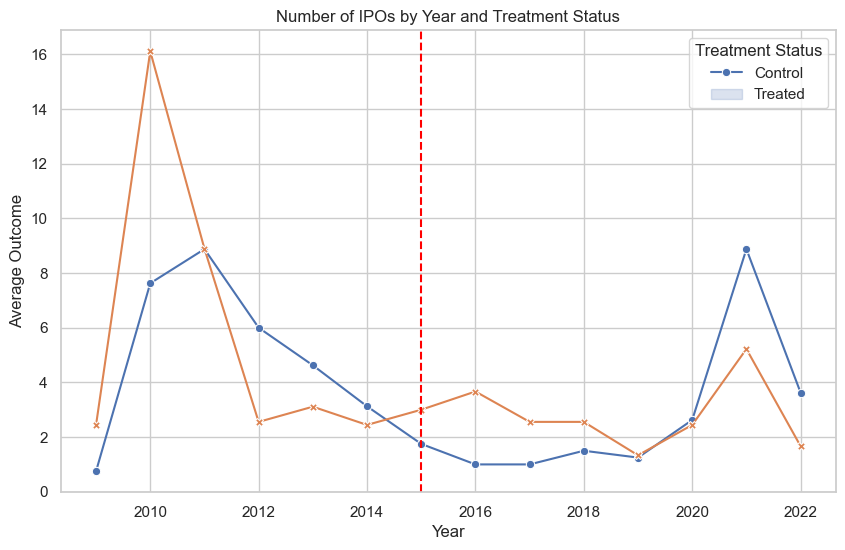

In [12]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='Year', y='IPOs_Number_of_Issues', hue='treated', style='treated', markers=True, dashes=False)

# Adding labels and title
plt.title('Number of IPOs by Year and Treatment Status')
plt.xlabel('Year')
plt.ylabel('Average Outcome')
plt.legend(title='Treatment Status', labels=['Control', 'Treated'])
plt.axvline(x=2015, color='red', linestyle='--')
plt.savefig('/Users/sonetalyn/Desktop/Thesis/IPOs_Number_of_Issues.png')
plt.show()

In [13]:
cleaned_data['intercept'] = 1
formula = """ IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention + GDP_Per_Capita__Dollar + Real_Private_Consumption_Growth__Percent + Real_Government_Consumption_Growth__Percent + Real_Gross_Fixed_Investment_Growth__Percent + Industrial_Production_Growth__Percent + intercept"""
cleaned_data['Population_Growth__Percent'] = pd.to_numeric(cleaned_data['Population_Growth__Percent'], errors='coerce')
cleaned_data['GDP_Per_Capita__Dollar'] = cleaned_data['GDP_Per_Capita__Dollar'].astype(str).str.replace(',', '').astype(float)
model = smf.ols(formula, data=cleaned_data).fit()

# Create a summary table of the results from the model
summary_table = summary_col([model], stars=True)

# Print the summary table
print(summary_table)

# Save the summary table to an HTML file
with open('/Users/sonetalyn/Desktop/Thesis/Controlled IPOs Number.html', 'w') as f:
    f.write(summary_table.as_html())


                                            IPOs_Number_of_Issues
-----------------------------------------------------------------
Intercept                                   1.5109               
                                            (1.0807)             
treated                                     1.4122               
                                            (2.5966)             
post_intervention                           -3.5432              
                                            (2.4007)             
treated_intervention                        -2.4661              
                                            (3.2441)             
GDP_Per_Capita__Dollar                      0.0001               
                                            (0.0001)             
Real_Private_Consumption_Growth__Percent    0.5938***            
                                            (0.2040)             
Real_Government_Consumption_Growth__Percent 0.4031*              
         

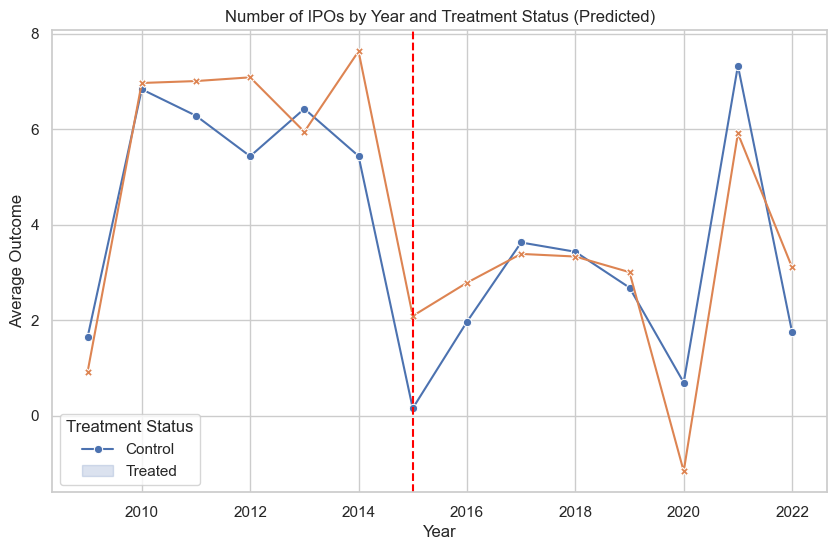

In [15]:
# Fit the model
model = smf.ols(formula, data=cleaned_data).fit()

# Generate predicted values
cleaned_data['predicted'] = model.predict(cleaned_data)

# Group the data by 'Year' and 'treated', and calculate the mean of 'predicted'
grouped_data = cleaned_data.groupby(['Year', 'treated'])['predicted'].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='Year', y='predicted', hue='treated', style='treated', markers=True, dashes=False)

# Adding labels and title
plt.title('Number of IPOs by Year and Treatment Status (Predicted)')
plt.xlabel('Year')
plt.ylabel('Average Outcome')
plt.legend(title='Treatment Status', labels=['Control', 'Treated'])
plt.axvline(x=2015, color='red', linestyle='--')

# Save the plot
plt.savefig('/Users/sonetalyn/Desktop/Thesis/Controlled Number of IPOs.png')

# Show the plot
plt.show()

## Fixed Effects with Country and Year

In [137]:
formula = 'IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention + C(Year) + C(Country)'
model = smf.ols(formula, data=cleaned_data).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     IPOs_Number_of_Issues   R-squared:                       0.480
Model:                               OLS   Adj. R-squared:                  0.404
Method:                    Least Squares   F-statistic:                     6.362
Date:                   Mon, 20 May 2024   Prob (F-statistic):           8.36e-17
Time:                           13:00:56   Log-Likelihood:                -858.75
No. Observations:                    238   AIC:                             1780.
Df Residuals:                        207   BIC:                             1887.
Df Model:                             30                                         
Covariance Type:               nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

# Adding control variables

In [160]:
print(cleaned_data.columns)

Index(['Year', 'Country', 'Proceeds_Amount_+_Over_Sold_This_Market_USD,_mln',
       'IPO_market_share', 'New_Business', 'IPOs_Number_of_Issues',
       'P/E_Ratio', 'E/P_ratio', 'Stock_Market_Index',
       'Interest_rate_up_to_1_mln', 'Interest_rate_over_€1M',
       'Aver_interest_rate_to_nonfinance', 'Real_GDP_Growth_Percent',
       'Nominal_GDP_DollarB', 'Population_M', 'Population_Growth_Percent',
       'GDP_Per_Capita_Dollar', 'Real_Private_Consumption_Growth_Percent',
       'Real_Government_Consumption_Growth_Percent',
       'Real_Gross_Fixed_Investment_Growth_Percent',
       'Industrial_Production_Growth_Percent', 'treated', 'post_intervention',
       'treated_intervention'],
      dtype='object')


In [161]:
formula = 'IPOs_Number_of_Issues ~ treated + post_intervention + treated_intervention + C(Year) + C(Country) + Population_Growth_Percent + GDP_Per_Capita_Dollar + Real_Private_Consumption_Growth_Percent + Real_Government_Consumption_Growth_Percent + Real_Gross_Fixed_Investment_Growth_Percent + Industrial_Production_Growth_Percent'
model = smf.ols(formula, data=cleaned_data).fit()
print(model.summary())

                              OLS Regression Results                             
Dep. Variable:     IPOs_Number_of_Issues   R-squared:                       1.000
Model:                               OLS   Adj. R-squared:                  0.993
Method:                    Least Squares   F-statistic:                     146.0
Date:                   Mon, 20 May 2024   Prob (F-statistic):           9.87e-13
Time:                           13:10:11   Log-Likelihood:                -6.5556
No. Observations:                    236   AIC:                             459.1
Df Residuals:                         13   BIC:                             1232.
Df Model:                            222                                         
Covariance Type:               nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------